In [1]:
import warnings
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from scipy.stats import shapiro, kstest
from sklearn.decomposition import PCA
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score

# Dont print warnings
warnings.simplefilter(action="ignore")

C:\Users\Gerax\AppData\Local\Temp\ipykernel_8496\4174796523.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# No copiar esto

In [2]:
# Step 1: Get all CSV file paths
csv_files = glob.glob("data/*.CSV")

# Step 2: Define a generator to read and process each file on the fly
def read_and_clean(file):
    df = pd.read_csv(file)
    return df

# Step 3: Merge without storing copies
merged_df = pd.concat((read_and_clean(file) for file in csv_files), ignore_index=True)

numerical_var = ["EDADHOM", "EDADMUJ"]
categorical_var = [
    "DEPREG",
    "MUPREG",
    "MESREG",
    "AÑOREG",
    "DIAOCU",
    "MESOCU",
    "AÑOOCU",
    "DEPOCU",
    "MUPOCU",
    "PUEHOM", 
    "PUEMUJ", 
    "NACHOM", 
    "NACMUJ", 
    "ESCHOM", 
    "ESCMUJ", 
    "CIUOMUJ", 
    "CIUOHOM"]

DEPREG = {
    1: "Guatemala",
    2: "El Progreso",
    3: "Sacatepéquez",
    4: "Chimaltenango",
    5: "Escuintla",
    6: "Santa Rosa",
    7: "Sololá",
    8: "Totonicapán",
    9: "Quetzaltenango",
    10: "Suchitepéquez",
    11: "Retalhuleu",
    12: "San Marcos",
    13: "Huehuetenango",
    14: "Quiché",
    15: "Baja Verapaz",
    16: "Alta Verapaz",
    17: "Petén",
    18: "Izabal",
    19: "Zacapa",
    20: "Chiquimula",
    21: "Jalapa",
    22: "Jutiapa"
}

MUPREG = {
    "0101": "Guatemala",
    "0102": "Santa Catarina Pinula",
    "0103": "San José Pinula",
    "0104": "San José del Golfo",
    "0105": "Palencia",
    "0106": "Chinautla",
    "0107": "San Pedro Ayampuc",
    "0108": "Mixco",
    "0109": "San Pedro Sacatepéquez",
    "0110": "San Juan Sacatepéquez",
    "0111": "San Raymundo",
    "0112": "Chuarrancho",
    "0113": "Fraijanes",
    "0114": "Amatitlán",
    "0115": "Villa Nueva",
    "0116": "Villa Canales",
    "0117": "Petapa",
    "0201": "Guastatoya",
    "0202": "Morazán",
    "0203": "San Agustín Acasaguastlán",
    "0204": "San Cristóbal Acasaguastlán",
    "0205": "El Jícaro",
    "0206": "Sansare",
    "0207": "Sanarate",
    "0208": "San Antonio la Paz",
    "0301": "Antigua Guatemala",
    "0302": "Jocotenango",
    "0303": "Pastores",
    "0304": "Sumpango",
    "0305": "Santo Domingo Xenacoj",
    "0306": "Santiago Sacatepéquez",
    "0307": "San Bartolomé Milpas Altas",
    "0308": "San Lucas Sacatepéquez",
    "0309": "Santa Lucía Milpas Altas",
    "0310": "Magdalena Milpas Altas",
    "0311": "Santa María de Jesús",
    "0312": "Ciudad Vieja",
    "0313": "San Miguel Dueñas",
    "0314": "Alotenango",
    "0315": "San Antonio Aguas Calientes",
    "0316": "Santa Catarina Barahona",
    "0401": "Chimaltenango",
    "0402": "San José Poaquil",
    "0403": "San Martín Jilotepeque",
    "0404": "Comalapa",
    "0405": "Santa Apolonia",
    "0406": "Tecpán Guatemala",
    "0407": "Patzún",
    "0408": "Pochuta",
    "0409": "Patzicía",
    "0410": "Santa Cruz Balanyá",
    "0411": "Acatenango",
    "0412": "Yepocapa",
    "0413": "San Andrés Itzapa",
    "0414": "Parramos",
    "0415": "Zaragoza",
    "0416": "El Tejar",
    "0501": "Escuintla",
    "0502": "Santa Lucía Cotzumalguapa",
    "0503": "La Democracia",
    "0504": "Siquinalá",
    "0505": "Masagua",
    "0506": "Tiquisate",
    "0507": "La Gomera",
    "0508": "Guanagazapa",
    "0509": "San José",
    "0510": "Iztapa",
    "0511": "Palín",
    "0512": "San Vicente Pacaya",
    "0513": "Nueva Concepción",
    "0514": "Sipacate",
    "0601": "Cuilapa",
    "0602": "Barberena",
    "0603": "Santa Rosa de Lima",
    "0604": "Casillas",
    "0605": "San Rafael las Flores",
    "0606": "Oratorio",
    "0607": "San Juan Tecuaco",
    "0608": "Chiquimulilla",
    "0609": "Taxisco",
    "0610": "Santa María Ixhuatán",
    "0611": "Guazacapán",
    "0612": "Santa Cruz Naranjo",
    "0613": "Pueblo Nuevo Viñas",
    "0614": "Nueva Santa Rosa",
    "0701": "Sololá",
    "0702": "San José Chacayá",
    "0703": "Santa María Visitación",
    "0704": "Santa Lucía Utatlán",
    "0705": "Nahualá",
    "0706": "Santa Catarina Ixtahuacán",
    "0707": "Santa Clara la Laguna",
    "0708": "Concepción",
    "0709": "San Andrés Semetabaj",
    "0710": "Panajachel",
    "0711": "Santa Catarina Palopó",
    "0712": "San Antonio Palopó",
    "0713": "San Lucas Tolimán",
    "0714": "Santa Cruz la Laguna",
    "0715": "San Pablo la Laguna",
    "0716": "San Marcos la Laguna",
    "0717": "San Juan la Laguna",
    "0718": "San Pedro la Laguna",
    "0719": "Santiago Atitlán",
    "0801": "Totonicapán",
    "0802": "San Cristóbal Totonicapán",
    "0803": "San Francisco el Alto",
    "0804": "San Andrés Xecul",
    "0805": "Momostenango",
    "0806": "Santa María Chiquimula",
    "0807": "Santa Lucía la Reforma",
    "0808": "San Bartolo",
    "0901": "Quetzaltenango",
    "0902": "Salcajá",
    "0903": "Olintepeque",
    "0904": "San Carlos Sija",
    "0905": "Sibilia",
    "0906": "Cabricán",
    "0907": "Cajolá",
    "0908": "San Miguel Siguilá",
    "0909": "Ostuncalco",
    "0910": "San Mateo",
    "0911": "Concepción Chiquirichapa",
    "0912": "San Martín Sacatepéquez",
    "0913": "Almolonga",
    "0914": "Cantel",
    "0915": "Huitán",
    "0916": "Zunil",
    "0917": "Colomba",
    "0918": "San Francisco la Unión",
    "0919": "El Palmar",
    "0920": "Coatepeque",
    "0921": "Génova",
    "0922": "Flores Costa Cuca",
    "0923": "La Esperanza",
    "0924": "Palestina de los Altos",
    "1001": "Mazatenango",
    "1002": "Cuyotenango",
    "1003": "San Francisco Zapotitlán",
    "1004": "San Bernardino",
    "1005": "San José el Idolo",
    "1006": "Santo Domingo Suchitepéquez",
    "1007": "San Lorenzo",
    "1008": "Samayac",
    "1009": "San Pablo Jocopilas",
    "1010": "San Antonio Suchitepéquez",
    "1011": "San Miguel Panán",
    "1012": "San Gabriel",
    "1013": "Chicacao",
    "1014": "Patulul",
    "1015": "Santa Bárbara",
    "1016": "San Juan Bautista",
    "1017": "Santo Tomás la Unión",
    "1018": "Zunilito",
    "1019": "Pueblo Nuevo",
    "1020": "Río Bravo",
    "1021": "San José La Máquina",
    "1101": "Retalhuleu",
    "1102": "San Sebastián",
    "1103": "Santa Cruz Muluá",
    "1104": "San Martín Zapotitlán",
    "1105": "San Felipe",
    "1106": "San Andrés Villa Seca",
    "1107": "Champerico",
    "1108": "Nuevo San Carlos",
    "1109": "El Asintal",
    "1201": "San Marcos",
    "1202": "San Pedro Sacatepéquez",
    "1203": "San Antonio Sacatepéquez",
    "1204": "Comitancillo",
    "1205": "San Miguel Ixtahuacán",
    "1206": "Concepción Tutuapa",
    "1207": "Tacaná",
    "1208": "Sibinal",
    "1209": "Tajumulco",
    "1210": "Tejutla",
    "1211": "San Rafael Pié de la Cuesta",
    "1212": "Nuevo Progreso",
    "1213": "El Tumbador",
    "1214": "El Rodeo",
    "1215": "Malacatán",
    "1216": "Catarina",
    "1217": "Ayutla",
    "1218": "Ocós",
    "1219": "San Pablo",
    "1220": "El Quetzal",
    "1221": "La Reforma",
    "1222": "Pajapita",
    "1223": "Ixchiguán",
    "1224": "San José Ojetenán",
    "1225": "San Cristóbal Cucho",
    "1226": "Sipacapa",
    "1227": "Esquipulas Palo Gordo",
    "1228": "Río Blanco",
    "1229": "San Lorenzo",
    "1230": "La Blanca",
    "1301": "Huehuetenango",
    "1302": "Chiantla",
    "1303": "Malacatancito",
    "1304": "Cuilco",
    "1305": "Nentón",
    "1306": "San Pedro Necta",
    "1307": "Jacaltenango",
    "1308": "Soloma",
    "1309": "Ixtahuacán",
    "1310": "Santa Bárbara",
    "1311": "La Libertad",
    "1312": "La Democracia",
    "1313": "San Miguel Acatán",
    "1314": "San Rafael la Independencia",
    "1315": "Todos Santos Cuchumatán",
    "1316": "San Juan Atitán",
    "1317": "Santa Eulalia",
    "1318": "San Mateo Ixtatán",
    "1319": "Colotenango",
    "1320": "San Sebastián Huehuetenango",
    "1321": "Tectitán",
    "1322": "Concepción Huista",
    "1323": "San Juan Ixcoy",
    "1324": "San Antonio Huista",
    "1325": "San Sebastián Coatán",
    "1326": "Barillas",
    "1327": "Aguacatán",
    "1328": "San Rafael Petzal",
    "1329": "San Gaspar Ixchil",
    "1330": "Santiago Chimaltenango",
    "1331": "Santa Ana Huista",
    "1332": "Unión Cantinil",
    "1333": "Petatán",
    "1401": "Santa Cruz del Quiché",
    "1402": "Chiché",
    "1403": "Chinique",
    "1404": "Zacualpa",
    "1405": "Chajul",
    "1406": "Chichicastenango",
    "1407": "Patzité",
    "1408": "San Antonio Ilotenango",
    "1409": "San Pedro Jocopilas",
    "1410": "Cunén",
    "1411": "San Juan Cotzal",
    "1412": "Joyabaj",
    "1413": "Nebaj",
    "1414": "San Andrés Sajcabajá",
    "1415": "Uspantán",
    "1416": "Sacapulas",
    "1417": "San Bartolomé Jocotenango",
    "1418": "Canillá",
    "1419": "Chicamán",
    "1420": "Ixcán",
    "1421": "Pachalum",
    "1501": "Salamá",
    "1502": "San Miguel Chicaj",
    "1503": "Rabinal",
    "1504": "Cubulco",
    "1505": "Granados",
    "1506": "El Chol",
    "1507": "San Jerónimo",
    "1508": "Purulhá",
    "1601": "Cobán",
    "1602": "Santa Cruz Verapaz",
    "1603": "San Cristóbal Verapaz",
    "1604": "Tactic",
    "1605": "Tamahú",
    "1606": "Tucurú",
    "1607": "Panzós",
    "1608": "Senahú",
    "1609": "San Pedro Carchá",
    "1610": "San Juan Chamelco",
    "1611": "Lanquín",
    "1612": "Cahabón",
    "1613": "Chisec",
    "1614": "Chahal",
    "1615": "Fray Bartolomé de las Casas",
    "1616": "Santa Catalina la Tinta",
    "1617": "Raxruhá",
    "1701": "Flores",
    "1702": "San José",
    "1703": "San Benito",
    "1704": "San Andrés",
    "1705": "La Libertad",
    "1706": "San Francisco",
    "1707": "Santa Ana",
    "1708": "Dolores",
    "1709": "San Luis",
    "1710": "Sayaxché",
    "1711": "Melchor de Mencos",
    "1712": "Poptún",
    "1713": "Las Cruces",
    "1714": "El Chal",
    "1801": "Puerto Barrios",
    "1802": "Livingston",
    "1803": "El Estor",
    "1804": "Morales",
    "1805": "Los Amates",
    "1901": "Zacapa",
    "1902": "Estanzuela",
    "1903": "Río Hondo",
    "1904": "Gualán",
    "1905": "Teculután",
    "1906": "Usumatlán",
    "1907": "Cabañas",
    "1908": "San Diego",
    "1909": "La Unión",
    "1910": "Huité",
    "1911": "San Jorge",
    "2001": "Chiquimula",
    "2002": "San José La Arada",
    "2003": "San Juan Ermita",
    "2004": "Jocotán",
    "2005": "Camotán",
    "2006": "Olopa",
    "2007": "Esquipulas",
    "2008": "Concepción Las Minas",
    "2009": "Quetzaltepeque",
    "2010": "San Jacinto",
    "2011": "Ipala",
    "2101": "Jalapa",
    "2102": "San Pedro Pinula",
    "2103": "San Luis Jilotepeque",
    "2104": "San Manuel Chaparrón",
    "2105": "San Carlos Alzatate",
    "2106": "Monjas",
    "2107": "Mataquescuintla",
    "2201": "Jutiapa",
    "2202": "El Progreso",
    "2203": "Santa Catarina Mita",
    "2204": "Agua Blanca",
    "2205": "Asunción Mita",
    "2206": "Yupiltepeque",
    "2207": "Atescatempa",
    "2208": "Jerez",
    "2209": "El Adelanto",
    "2210": "Zapotitlán",
    "2211": "Comapa",
    "2212": "Jalpatagua",
    "2213": "Conguaco",
    "2214": "Moyuta",
    "2215": "Pasaco",
    "2216": "San José Acatempa",
    "2217": "Quesada"
}

MESREG = {
    1: "Enero",
    2: "Febrero",
    3: "Marzo",
    4: "Abril",
    5: "Mayo",
    6: "Junio",
    7: "Julio",
    8: "Agosto",
    9: "Septiembre",
    10: "Octubre",
    11: "Noviembre",
    12: "Diciembre"
}

MESOCU = MESREG
DEPOCU = DEPREG
MUPOCU = MUPREG

PUEHOM = PUEMUJ = {
    1: "Maya",
    2: "Garífuna",
    3: "Xinka",
    4: "Mestizo / Ladino",
    5: "Otro",
    9: "Ignorado"
}

ESCHOM = ESCMUJ = {
    1: "Ninguno",
    2: "Primaria",
    3: "Básica",
    4: "Diversificado",
    5: "Universitario",
    6: "Postgrado",
    9: "Ignorado"
}

ocupationsExcel = pd.read_excel('./data/Ocupaciones.xls')
CIUOHOM = CIUOMUJ = dict(zip(ocupationsExcel.iloc[:, 0], ocupationsExcel.iloc[:, 1]))
del ocupationsExcel

nacionality_man = pd.read_excel('./data/nacionalidad_hombre.xls').drop_duplicates()
NACHOM = dict(zip(nacionality_man.iloc[:, 0], nacionality_man.iloc[:, 1]))
del nacionality_man

nacionality_woman = pd.read_excel('./data/nacionalidad_mujer.xls').drop_duplicates()
NACMUJ = dict(zip(nacionality_woman.iloc[:, 0], nacionality_woman.iloc[:, 1]))
del nacionality_woman

df_null_values = merged_df[["EDADHOM", "EDADMUJ", "PUEHOM", "PUEMUJ", "NACHOM", "NACMUJ", "ESCHOM", "ESCMUJ", "CIUOMUJ", "CIUOHOM"]]
null_values = {
    "EDADHOM": 999,
    "EDADMUJ": 999,
    "PUEHOM": 9,
    "PUEMUJ": 9,
    "NACHOM": 9999,
    "NACMUJ": 9999,
    "ESCHOM": 9,
    "ESCMUJ": 9,
    "CIUOMUJ": 99,
    "CIUOHOM": 99
}

# function to count null-like values
def count_nulls(df, column, null_value):
    # Count how many times the null_value appears in the column
    return (df[column] == null_value).sum()

null_counts = {col: count_nulls(merged_df, col, null_vals) for col, null_vals in null_values.items()}

null_counts_df = pd.DataFrame(list(null_counts.items()), columns=["Variable", "Frecuencia de valores nulos"])
total_rows = len(merged_df)
null_counts_df["% de valores nulos"] = (null_counts_df["Frecuencia de valores nulos"] / total_rows) * 100
null_counts_df["% de valores nulos"] = null_counts_df["% de valores nulos"].round(1)

null_counts_df

def remove_outliers(dataframe):
    '''
    return a dataframe without rows that are outliers in any column
    '''
    return dataframe\
    .loc[:, lambda df: df.std() > 0.04]\
    .loc[lambda df: (np.abs(stats.zscore(df)) < 3).all(axis=1)]
print(merged_df.shape)
a = remove_outliers(merged_df)
print(a.shape)
merged_df = remove_outliers(merged_df)

def fill_column_with_rf(df, col, null_val):
    '''
    Fills a single column with missing values using RandomForestClassifier.
    
    Args:
        df: DataFrame containing the data with missing values.
        col: The column to fill.
        null_val: The value representing missing data.
    
    Returns:
        A pandas Series with the filled column values.
    '''
    # Create a copy of the dataframe to avoid modifying the original
    df_copy = df.copy()

    # Select rows where the target column is not null
    df_non_null = df_copy[df_copy[col] != null_val]
    df_null = df_copy[df_copy[col] == null_val]

    # Prepare X (features) and Y (target)
    X_train = df_non_null.drop(columns=[col])
    Y_train = df_non_null[col]

    # Prepare the test set (only the rows with missing values)
    X_test = df_null.drop(columns=[col])

    # Initialize the RandomForest model
    forest = RandomForestClassifier(n_estimators=45, max_depth=25, random_state=0, 
                                    max_features=0.6, min_samples_leaf=3, n_jobs=-1)

    # Train the model
    forest.fit(X_train, Y_train)

    # Predict missing values for the test set
    y_pred = forest.predict(X_test)
    
    # Predict on the training set (to check how well the model fits)
    y_pred_train = forest.predict(X_train)
    
    # Calculate and print the accuracy on the training data
    accuracy_train = accuracy_score(Y_train, y_pred_train)
    print(f"Accuracy de entrenamiento para {col}: {accuracy_train:.4f}")

    # Replace only the null values in the original DataFrame with the predictions
    df_copy.loc[df_copy[col] == null_val, col] = y_pred

    return df_copy[col]

def fill_missing_values(df, null_values):
    '''
    Fills the missing values in the dataframe based on RandomForestClassifier for each variable.
    
    Args:
        df: DataFrame containing the data with missing values.
        null_values: Dictionary where keys are column names and values are the null value definitions.
    
    Returns:
        DataFrame with missing values filled using Random Forest.
    '''
    # Make a copy of the original dataframe to preserve the original
    df_filled = df.copy()

    # Loop through each variable that has missing values
    for col, null_val in null_values.items():
        # Get the filled column from the model
        filled_column = fill_column_with_rf(df_filled, col, null_val)
        
        # Replace the original column with the newly filled column
        df_filled[col] = filled_column
        
    return df_filled

variables_to_predict = {
    "EDADHOM": 999,
    "EDADMUJ": 999,
    "PUEHOM": 9,
    "PUEMUJ": 9,
    "ESCHOM": 9,
    "ESCMUJ": 9,
    "CIUOMUJ": 99,
    "CIUOHOM": 99
}

# Assuming merged_df is your dataframe with missing values
filled_df = fill_missing_values(merged_df, variables_to_predict)
merged_df = filled_df

(76669, 19)
(76291, 19)
Accuracy de entrenamiento para EDADHOM: 0.9844
Accuracy de entrenamiento para EDADMUJ: 0.9804
Accuracy de entrenamiento para PUEHOM: 0.9575
Accuracy de entrenamiento para PUEMUJ: 0.9627
Accuracy de entrenamiento para ESCHOM: 0.8970
Accuracy de entrenamiento para ESCMUJ: 0.8998
Accuracy de entrenamiento para CIUOMUJ: 0.8784
Accuracy de entrenamiento para CIUOHOM: 0.8253


# Esto si xd

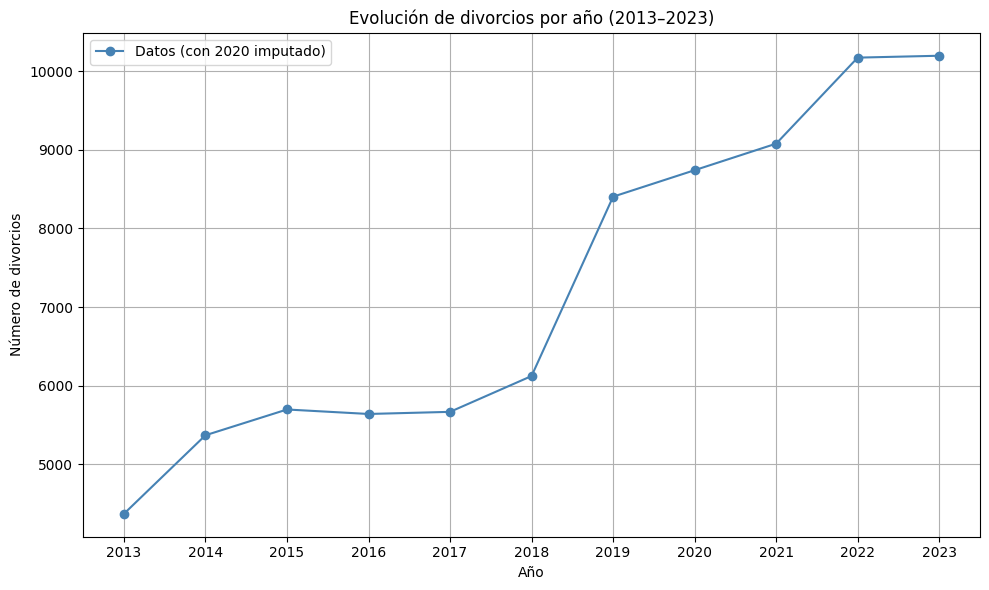

In [3]:
# Contar el número de divorcios por año
divorcios_por_año = merged_df["AÑOREG"].value_counts().sort_index()
divorcios_por_año = divorcios_por_año.loc[2013:2023]

# Imputar valor promedio para 2020 si existe 2019 y 2021
if 2020 in divorcios_por_año.index and 2019 in divorcios_por_año.index and 2021 in divorcios_por_año.index:
    divorcios_por_año.loc[2020] = int((divorcios_por_año.loc[2019] + divorcios_por_año.loc[2021]) / 2)


plt.figure(figsize=(10, 6))
plt.plot(divorcios_por_año.index, divorcios_por_año.values, marker='o', color='steelblue', label='Datos (con 2020 imputado)')
plt.title("Evolución de divorcios por año (2013–2023)")
plt.xlabel("Año")
plt.ylabel("Número de divorcios")
plt.grid(True)
plt.xticks(np.arange(2013, 2024))
plt.legend()
plt.tight_layout()
plt.show()

El año 2020 fue calculado e insertado en la serie de tiempo porque, al analizar el conjunto de datos, se identificó que existian datos, pero representaba un dato atipico que podia afecta a los modelos. Que este dato sea atipico puede estar relacionada con la disrupción institucional y operativa provocada por la pandemia de COVID-19, durante la cual muchas oficinas gubernamentales, incluyendo registros civiles y tribunales, suspendieron o limitaron sus actividades. Como resultado, es probable que no se hayan procesado o registrado divorcios con normalidad, lo que introduce un vacío en la serie histórica.

Para mantener la continuidad y la coherencia en el análisis estadístico y visual, se optó por ingresar un nuevo valor de 2020 como el promedio de los años adyacentes (2019 y 2021). Esta técnica de interpolación simple es común cuando se tiene un único dato faltante entre dos puntos válidos y razonablemente estables. Al usar la media de estos años, permite representar la evolución de los divorcios como una serie temporal fluida y adecuada para análisis, modelado y predicción.

## Data

In [5]:
# Data
train_years = np.array([year for year in divorcios_por_año.index if 2013 <= year <= 2021]).reshape(-1, 1)
train_values = divorcios_por_año.loc[2013:2021].values
test_years = np.array([2022, 2023]).reshape(-1, 1)
test_values = divorcios_por_año.loc[2022:2023].values

In [6]:
def evaluar(nombre, real, predicho):
    print(f"\nModelo: {nombre}")
    print("MAE:", round(mean_absolute_error(real, predicho), 2))
    print("RMSE:", round(np.sqrt(mean_squared_error(real, predicho)), 2))
    # No usar
    # print("R²:", round(r2_score(real, predicho), 4))

Para la evaluación del desempeño de los modelos se utilizarán las siguientes métricas:
* MAE (Mean Absolute Error): mide el promedio de los errores absolutos entre los valores reales y los predichos.
* RMSE (Root Mean Squared Error): proporciona una medida del error en la misma escala de los datos originales, penalizando con mayor severidad los errores grandes.

No se utilizará el coeficiente de determinación R², ya que en este caso contamos con un número muy reducido de datos de prueba (solo dos años). Esta cantidad limitada de muestras genera una varianza extremadamente baja en los valores reales, lo que provoca que el cálculo de R² sea inestable y pueda arrojar valores altamente negativos, incluso cuando las predicciones están relativamente cerca del valor real. Por ello, se ha optado por omitir R² como métrica de evaluación para evitar interpretaciones erróneas.

### Regresion Lineal

In [7]:
linear_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

linear_model = TransformedTargetRegressor(regressor=linear_pipeline, transformer=StandardScaler())

# Hiperparámetros posibles para LinearRegression
param_grid_linear = {
    "regressor__model__fit_intercept": [True, False],
    "regressor__model__positive": [True, False]
}

# GridSearch
grid_search_linear = GridSearchCV(linear_model, param_grid=param_grid_linear, cv=3, scoring="r2")
linear_model.fit(train_years, train_values)
linear_preds = linear_model.predict(test_years)

evaluar("Lineal", test_values, linear_preds)

print("\nReales vs Predichos (2022-2023)")
for año, real, pred in zip(test_years.flatten(), test_values.flatten(), linear_preds):
    print(f"{año}: real={real:.1f}, pred={pred:.1f}")



Modelo: Lineal
MAE: 425.38
RMSE: 508.49

Reales vs Predichos (2022-2023)
2022: real=10175.0, pred=9471.0
2023: real=10199.0, pred=10052.2


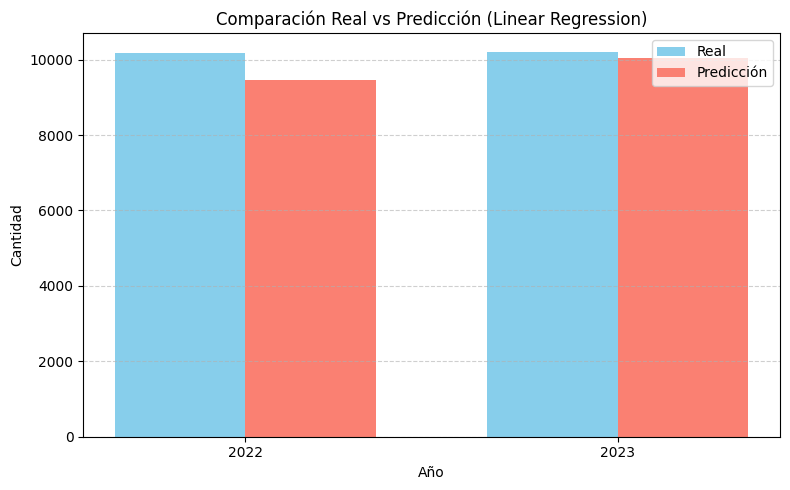

In [8]:
años = test_years.flatten()

bar_width = 0.35
index = np.arange(len(años))

plt.figure(figsize=(8, 5))
plt.bar(index, test_values, bar_width, label='Real', color='skyblue')
plt.bar(index + bar_width, linear_preds, bar_width, label='Predicción', color='salmon')

plt.xlabel('Año')
plt.ylabel('Cantidad')
plt.title('Comparación Real vs Predicción (Linear Regression)')
plt.xticks(index + bar_width / 2, años)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [9]:
future_years = np.array([2024, 2025, 2026, 2027, 2028]).reshape(-1, 1)
future_preds = linear_model.predict(future_years)
print("\nPredicciones para 2024–2028:", np.round(future_preds, 2))


Predicciones para 2024–2028: [10633.39 11214.58 11795.76 12376.94 12958.13]


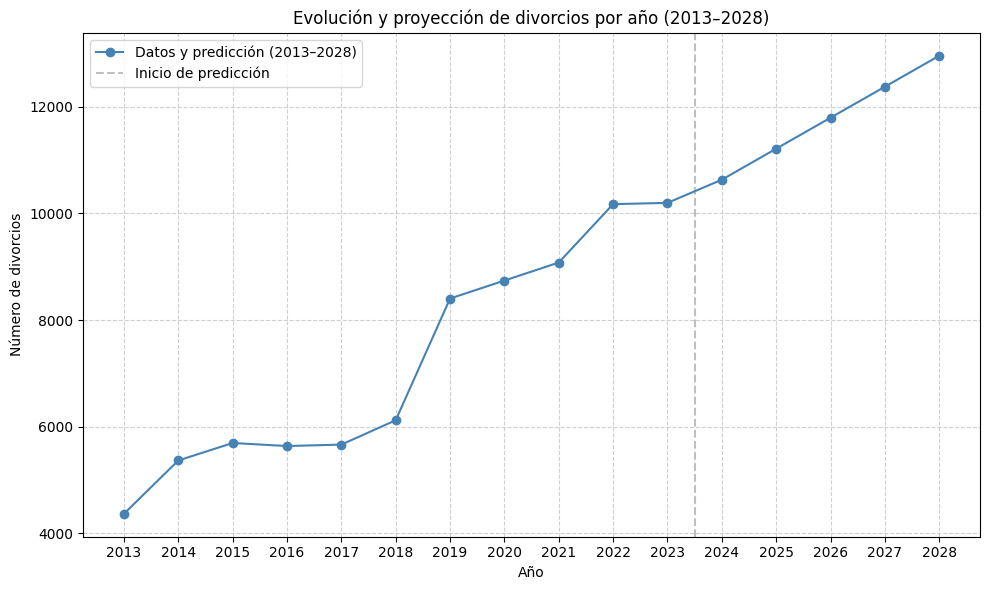

In [10]:
all_years = np.concatenate([divorcios_por_año.index.values, future_years.flatten()])
all_values = np.concatenate([divorcios_por_año.values, future_preds])

# Graficar como una sola línea continua
plt.figure(figsize=(10, 6))
plt.plot(all_years, all_values, marker='o', color='steelblue', label='Datos y predicción (2013–2028)')

# Línea vertical para indicar inicio de proyecciones
plt.axvline(x=2023.5, color='gray', linestyle='--', alpha=0.5, label='Inicio de predicción')

plt.title("Evolución y proyección de divorcios por año (2013–2028)")
plt.xlabel("Año")
plt.ylabel("Número de divorcios")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(np.arange(2013, 2029))
plt.legend()
plt.tight_layout()
plt.show()

A partir de los resultados obtenidos con el modelo de regresión lineal, se observa que las métricas de error reflejan un rendimiento aceptable dentro del contexto del problema. El MAE fue de 425.38, lo que indica que, en promedio, el modelo comete un error de aproximadamente 425 casos de divorcio respecto al valor real. Por otro lado, el RMSE fue de 508.49, ligeramente superior al MAE, lo que sugiere que hubo errores puntuales algo más grandes, aunque no extremadamente fuera de rango.

Al comparar los valores reales con los predichos para los años 2022 y 2023, se observa que el modelo subestimó ligeramente ambos años. Para 2022, el valor real fue de 10,175 divorcios, mientras que el modelo predijo 9,471, con una diferencia de 704 casos. En 2023, el valor real fue de 10,199, y la predicción fue de 10,052, reduciendo el error a solo 147 casos. Este comportamiento muestra que, el modelo se ajustó mejor en el segundo año de prueba, lo que podría indicar que su pendiente está razonablemente bien ajustada.

Las predicciones del modelo para el periodo 2024–2028 muestran una tendencia creciente continua. Los valores predichos son: 10,633.39 en 2024, 11,214.58 en 2025, 11,795.76 en 2026, 12,376.94 en 2027 y 12,958.13 en 2028. Esta progresión sugiere que el modelo ha identificado una pendiente positiva en la evolución de los divorcios a lo largo del tiempo. Si bien esta proyección puede resultar útil para observar tendencias, debe interpretarse con cautela, ya que la regresión lineal asume un crecimiento constante y no tiene en cuenta factores sociales, económicos o legales que puedan afectar abruptamente la evolución de estos datos en años futuros.


### Red Neuronal

In [11]:
mlp_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", MLPRegressor(max_iter=2000, early_stopping=True, random_state=42))
])
mlp_model = TransformedTargetRegressor(regressor=mlp_pipeline, transformer=StandardScaler())

param_grid = {
    'regressor__model__hidden_layer_sizes': [
    (4, 3), (5, 3), (6, 4), (7, 3), (8, 5), (5,)
    ],
    "regressor__model__activation": ["tanh", "logistic"],
    "regressor__model__solver": ["adam", "lbfgs"],
    'regressor__model__learning_rate_init': (0.01, 0.1, 1,10)
}

grid_search = GridSearchCV(mlp_model, param_grid, cv=3, scoring="r2")
grid_search.fit(train_years, train_values)
# print(grid_search.best_params_)
mlp_preds = grid_search.predict(test_years)

In [ ]:
evaluar("MLP (GridSearch 1)", test_values, mlp_preds)


print("\nReales vs Predichos (2022-2023)")
for año, real, pred in zip(test_years.flatten(), test_values.flatten(), mlp_preds):
    print(f"{año}: real={real:.1f}, pred={pred:.1f}")



Modelo: MLP (GridSearch)
MAE: 415.16
RMSE: 481.84

Reales vs Predichos (2022-2023)
2022: real=10175.0, pred=9515.3
2023: real=10199.0, pred=10028.4


In [13]:
mlp_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", MLPRegressor(max_iter=2000, early_stopping=True, random_state=42))
])
mlp_model = TransformedTargetRegressor(regressor=mlp_pipeline, transformer=StandardScaler())

param_grid = {
    'regressor__model__hidden_layer_sizes': [
        (5,), (10,), (15,),         # una capa oculta
        (10, 5), (20, 10), (30, 15), # dos capas
        (10, 10, 5)                  # tres capas
    ],
    'regressor__model__activation': ['logistic'],  # solo logistic
    'regressor__model__solver': ['adam', 'lbfgs'],
    'regressor__model__learning_rate_init': [0.001, 0.01, 0.05, 0.1]
}

grid_search2 = GridSearchCV(mlp_model, param_grid, cv=3, scoring="r2")
grid_search2.fit(train_years, train_values)
# print(grid_search2.best_params_)
mlp_preds2 = grid_search2.predict(test_years)

In [14]:
evaluar("MLP (GridSearch 2)", test_values, mlp_preds2)


print("\nReales vs Predichos (2022-2023)")
for año, real, pred in zip(test_years.flatten(), test_values.flatten(), mlp_preds2):
    print(f"{año}: real={real:.1f}, pred={pred:.1f}")



Modelo: MLP (GridSearch 2)
MAE: 702.13
RMSE: 714.79

Reales vs Predichos (2022-2023)
2022: real=10175.0, pred=9338.9
2023: real=10199.0, pred=9630.8


In [ ]:
mlp_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", MLPRegressor(max_iter=2000, early_stopping=True, random_state=42))
])
mlp_model = TransformedTargetRegressor(regressor=mlp_pipeline, transformer=StandardScaler())

param_grid = {
    'regressor__model__hidden_layer_sizes': [
        (16,), (32,), (64,),                  
        (32, 16), (64, 32), (128, 64),        
        (64, 64), (128, 128),                 
        (128, 64, 32), (64, 32, 16),          
        (32, 64, 32), (64, 128, 64),          
        (100, 50, 25), (50, 100, 50),         
    ],
    'regressor__model__activation': ['tanh'],
    'regressor__model__solver': ['adam', 'lbfgs'],
    'regressor__model__learning_rate_init': [0.001, 0.005, 0.01]
}

grid_search3 = GridSearchCV(mlp_model, param_grid, cv=3, scoring="r2")
grid_search3.fit(train_years, train_values)
print(grid_search3.best_params_)
mlp_preds3 = grid_search3.predict(test_years)

{'regressor__model__activation': 'tanh', 'regressor__model__hidden_layer_sizes': (32, 64, 32), 'regressor__model__learning_rate_init': 0.001, 'regressor__model__solver': 'lbfgs'}


In [16]:
evaluar("MLP (GridSearch 3)", test_values, mlp_preds3)


print("\nReales vs Predichos (2022-2023)")
for año, real, pred in zip(test_years.flatten(), test_values.flatten(), mlp_preds3):
    print(f"{año}: real={real:.1f}, pred={pred:.1f}")



Modelo: MLP (GridSearch 3)
MAE: 630.58
RMSE: 643.94

Reales vs Predichos (2022-2023)
2022: real=10175.0, pred=9413.9
2023: real=10199.0, pred=9698.9


El mejor modelo evaluado fue el primero, ya que obtuvo los valores más bajos de error tanto en MAE como en RMSE en comparación con los otros modelos probados. Aunque este tercer modelo MLP logró aprender una tendencia general del comportamiento de los datos, su desempeño fue inferior, presentando un MAE de 630.58 y un RMSE de 643.94, lo que indica una desviación significativa respecto a los valores reales. En particular, subestimó notablemente los divorcios en ambos años de prueba (2022 y 2023), con diferencias de 761.1 y 500.1 casos, respectivamente. Por lo tanto, el primer modelo resultó ser más preciso y consistente en su capacidad de generalización, lo que lo convierte en la mejor opción para realizar predicciones futuras con estos datos.

En base a esto se utilizara el primer modelo.

Si lees esto es porque el commit es muy "significativo".

### Con el primer modelo: